# With an Event Data Model

Lets see if we can't build something that has a sort-of event data model that looks a lot like awkward, but does "the right thing" in the queries, and returns awkward events.

The EDM is pretty simple:

* An object that represents all events
* It has a jet collection (which is named)
* The jets have pt and eta columns.

## Difference from the first EDM notebook:

After talking with Lindsey we discovered that we don't need to know the number of partitions when we create the expression. It is only needed at evaluation.

Given the way ServiceX works now, we can wait until SX returns the number of files - and as soon as that happens, we can then return the number of layers.

If all goes well, this happens only after full optimization is done, that way we will know the "useful" columns before this has to be filled in.

In [1]:
import dask_histogram as dh
import mplhep as hep
import dask_awkward as dak
import uproot
import awkward as ak
from pathlib import Path
import dask

from typing import Dict, List, Iterable

# We will use this as dummy data - this is from a real SX query, so even if the column
# names are wrong, at least the "form" of the data is as it would be.
root_file = Path("0fc6e51a5ea6dea107c195591d20a1b2-15.26710677._000019.pool.root.1")

## Array Input Source

Code to manage the query. There are several components. The design is driven by my understanding of how `dask` and `dask-awkward` work.

* A central query manager
    * One per dataset that will be queried
    * Collects all the columns that we will want form ServiceX
    * When the `.compute()` triggers the calculation, this triggers the query to ServiceX
    * Only one query is made for all columns
* `dask` `ArrayInputLayer`
    * Holds onto the query manager and the particular queried column that needs to be fetched from the query
    * Depending on how `dask` is running, many requests may come in for the same query at about the same time
    * Will likely need to be thread safe
    * Though not done here, there is no reason not to use the async interface that comes back from SX, so you can pump the data through the system naturally as it arrives.

First up is the ServiceX query manager. There is one of these per dataset.

In [2]:
class sx_query_manager:
    def __init__(self, queries: Dict[str, str]):
        '''Create a query manager. When triggered, takes all the queries, combines them, and triggers SX and waits for the files to all come back.'''
        self._queries = queries
        # This would probably end up being a mutex of some sort.
        # TODO how do we to multiple queries? There is probably something basic missing in the design for
        # that.
        self._query_done = False
    
    @property
    def inputs(self) -> List[str]:
        '''Return the names of the partitions
        TODO: We might not know this actual number until the SX query is well under
        way, and so it might be different from the number of partitions.
        So - this is determined only when the query is executed!!
        This could be, for example, the URL objects referencing minio filenames names in the query bucket.
        '''
        if not self._query_done:
            self._query_done = True
            # TODO: Magic code to combine all the queries
            print(f"Just did query for {self._queries.keys()} (and {self._queries.values()})")
        return [f'part_{i}' for i in range(0, self.npartitions)]
    
    @property
    def ninputs(self) -> int:
        '''Number of actual input partitions after the query is under way'''
        # TODO: this would need to block on a new query till we knew the number of queries
        return len(self.inputs)

    @property
    def npartitions(self) -> int:
        '''Return the number of partitions in the data'''

        # TODO: SX Dataset will need a new property/method that will
        # return the number of data partitions coming back, or a default
        # value if this is a new dataset (say 10, from the other sample
        # code here in this guy).
        return 10
    
    @property
    def metadata(self) -> ak.Array:
        '''Return the metadata for the query'''
        # Build the metadata for this array we will be returning. Each partition
        # will be of this form.
        sample_array = ak.from_iter([[1.0, 2.1], [3.2], [], [4.3, 5.4]])
        return dak.core.typetracer_array(sample_array)



In [3]:
def make_input_layer(name: str, leaf_name: str, query_manager: sx_query_manager):
    '''Create an AwkwardInput layer with however many chunks the query from SX
    is going to return.

    Use `query_manager` to understand the number of input files that will come back
    from SX. Normally the number of partitions would be the same, unless this is a new
    dataset and we've never made a query before.

    Args:
        name(str): Unique name for internal reference
        leaf_name(str): In the query, this is the column we are interested in
        query_manager(sx_query_manager): What manages the actual query

    Returns:
        AwkwardInputLayer: Input Layer
    '''
    def generate_data(block):
        '''Generate the data for a particular partition. We have the job of
        figuring out how many files per partition.

        Args:
            block (int): The block number
        '''
        # This will be a list of things we'll use uproot to open.
        files = []

        if query_manager.ninputs <= query_manager.npartitions:
            if block < query_manager.ninputs:
                files = [generate_partition_data(query_manager.inputs[block])]
            else:
                return ak.from_iter([])
        else:
            num_per = int(query_manager.ninputs / query_manager.npartitions)
            if block < (query_manager.ninputs - num_per*query_manager.npartitions):
                num_per += 1
            
            # The indexing has a bug - will come back to this eventually
            # Not important for now.
            block_index = num_per * block
            files = [generate_partition_data(query_manager.inputs[block_index + i]) for i in range(0, num_per)]

        # files = uproot.dask(file_list)
        # pt = files['JetPt']
        # TODO: would use `leaf_name rather than `JetPt`
        all_pt = [uproot.open(f_name)['treeme']['JetPt'].array(library='ak') for f_name in files]  # type: ignore
        pt = ak.concatenate(all_pt)
        return pt

    def generate_partition_data(block):
        '''Generate the partition data for a single block.

        Args:
            block (_type_): _description_

        Returns:
            _type_: _description_
        '''
        print(f'In generate_data: {block}')
        return root_file

    # Next, create the input layer that will be used to generate the data.
    # Always setup 10 partitions
    dsk = dak.layers.AwkwardInputLayer(
            name=name,
            inputs=list(range(0, query_manager.npartitions)),
            io_func=generate_data,
            # meta=metadata,
            # behavior=None,
        )

    return dsk

Finally, generate the actual `dask-awkward` array that downstream can use.

In [4]:
def generate_sx_daq(sx_leaf_name: str, query_manager: sx_query_manager) -> dak.Array:
    name = 'unique-name'
    input_layer = make_input_layer(name, sx_leaf_name, query_manager)

    # Create the high level graph that will hold all of this, and the actual array object
    hlg = dask.highlevelgraph.HighLevelGraph.from_collections(name, input_layer)  # type: ignore
    ar = dak.core.new_array_object(hlg, name, meta=query_manager.metadata, npartitions=query_manager.npartitions)

    return ar

## EDM

Define a really simple edm that takes (some) parameters.

In [5]:
class jets:
    '''Represents a collection of jets'''

    def __init__(self, base_obj, base_query: str, name_stub: str):
        self._query = base_query
        self._parent_edm = base_obj
        self._name_stub = name_stub

    def pt(self) -> dak.Array:
        '''Return the jet $p_T$ for all events (assuming xAOD-like objects)'''
        # NOTE: in real code this would be lambda's in code that build an ast
        query = f'{self._query}.Select(j: j.pt())'
        return self._parent_edm._add_query(f'{self._name_stub}_pt', query)

    def eta(self) -> dak.Array:
        r'''Return the jet $\eta$ for all events'''
        # NOTE: in real code this would be lambda's in code that build an ast
        query = f'{self._query}.Select(j: j.eta())'
        return self._parent_edm._add_query(f'{self._name_stub}_eta', query)

class events:
    '''Represents all events in a file'''
    def __init__(self, base_query="sx_datasource"):
        self._my_jets: Dict[str, jets] = {}
        self._query = base_query
        self._sx_columns: Dict[str, str] = {}
        self._sx_col_arrays: Dict[str, dak.Array] = {}
        self._sx_query_manager = None

    def _add_query(self, name: str, query: str) -> dak.Array:
        '''Add a query to the SX backend so when we "run" we actually execute the query.
        Return the data in `name` column in the sx query
        Return a dask/awkward builder that knows how to make the full query when
        the compute is hit.
        '''
        # Return an Array for this query.
        # NB: Since Awkward and dask need to know *everything* before they can even form the
        # compute graph, we have to return an array here. Each repeated request will do the same.
        # That said, if multiple things are requested, they will be tied to a single SX transaction.
        # This makes a mess of sync when things are running on multiple threads, but don't see a way
        # to untie this.
        if self._sx_query_manager is None:
            # Note that `_sx_columns` is a dict and passed in by reference
            self._sx_query_manager = sx_query_manager(self._sx_columns)

        # Create the array output layer
        if name not in self._sx_columns:
            d_array = generate_sx_daq(name, self._sx_query_manager)
            self._sx_columns[name] = query
            self._sx_col_arrays[name] = d_array

        # Return the array for use by user
        return self._sx_col_arrays[name]        

    def jets(self, jet_collection_name: str) -> jets:
        '''Return the jet collection'''
        if jet_collection_name not in self._my_jets:
        # NOTE: in real code this would be lambda's in code that build an ast
            query = f'{self._query}.Select(e: e.Jets("{jet_collection_name}"))'
            self._my_jets[jet_collection_name] = jets(self, query, jet_collection_name)
        return self._my_jets[jet_collection_name]

## Make a histogram of jet $p_T$

Start with something really simple.

Just did query for dict_keys(['antipflow_pt']) (and dict_values(['sx_datasource.Select(e: e.Jets("antipflow")).Select(j: j.pt())']))
In generate_data: part_7
In generate_data: part_3
In generate_data: part_0
In generate_data: part_4
In generate_data: part_1
In generate_data: part_2
In generate_data: part_5
In generate_data: part_6
In generate_data: part_9
In generate_data: part_8


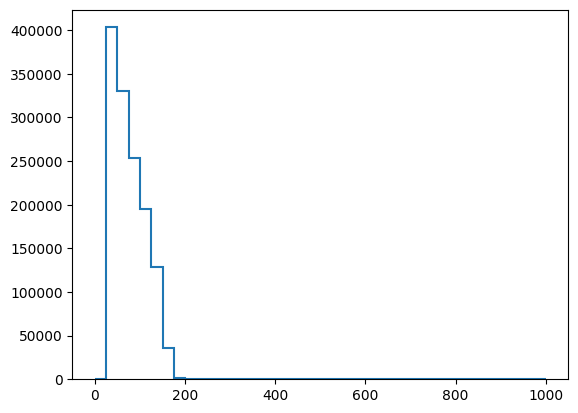

In [6]:
e = events()
x = e.jets('antipflow').pt()

h = dh.factory(dak.flatten(x), axes=(dh.axis.Regular(40, 0, 1000),))
r = h.compute()
_ = hep.histplot(r)

## Two variables

This just double checks that the code to accumulate different items will work.

Just did query for dict_keys(['antipflow_pt', 'antipflow_eta']) (and dict_values(['sx_datasource.Select(e: e.Jets("antipflow")).Select(j: j.pt())', 'sx_datasource.Select(e: e.Jets("antipflow")).Select(j: j.eta())']))
In generate_data: part_7
In generate_data: part_5
In generate_data: part_2
In generate_data: part_6
In generate_data: part_3
In generate_data: part_0
In generate_data: part_1
In generate_data: part_4
In generate_data: part_9
In generate_data: part_8
Just did query for dict_keys(['antipflow_pt', 'antipflow_eta']) (and dict_values(['sx_datasource.Select(e: e.Jets("antipflow")).Select(j: j.pt())', 'sx_datasource.Select(e: e.Jets("antipflow")).Select(j: j.eta())']))In generate_data: part_4
In generate_data: part_1
In generate_data: part_2

In generate_data: part_7
In generate_data: part_5
In generate_data: part_6
In generate_data: part_3
In generate_data: part_0
In generate_data: part_9
In generate_data: part_8


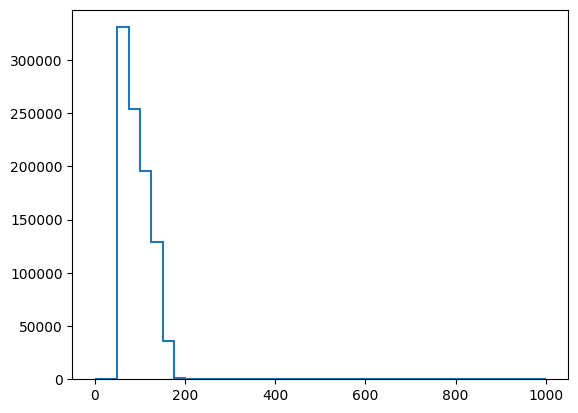

In [7]:
e = events()
pt = e.jets('antipflow').pt()
eta = e.jets('antipflow').eta()

# Remember that we don't really have eta - just pt duplicated, so this
# cut is nothing more than a demo
good_pt = pt[eta > 50]

h = dh.factory(dak.flatten(good_pt), axes=(dh.axis.Regular(40, 0, 1000),))
r = h.compute()
_ = hep.histplot(r)

## Unused variable

Do not actually know how to make this work.

The below query generates the proper result, but even though it doesn't need eta, it still asks for it from ServiceX.

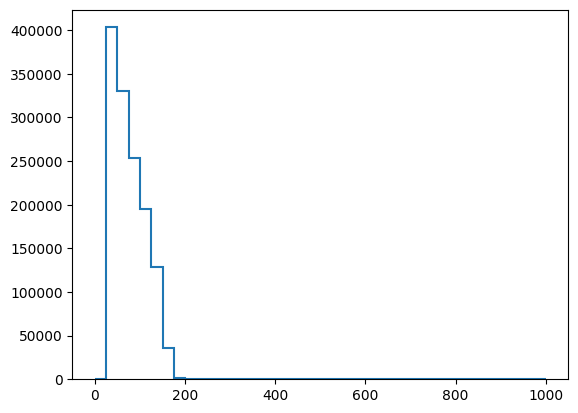

In [8]:
e = events()
pt = e.jets('antipflow').pt()
eta = e.jets('antipflow').eta()

# Remember that we don't really have eta - just pt duplicated, so this
# cut is nothing more than a demo
good_pt = pt[eta > 50]

# Note good_pt and thus eta are not actually needed.
h = dh.factory(dak.flatten(pt), axes=(dh.axis.Regular(40, 0, 1000),))
r = h.compute()
_ = hep.histplot(r)